In [137]:
import numpy as np
import matplotlib.pyplot as plt
import json
from nltk.tokenize import sent_tokenize, word_tokenize
import collections
import itertools
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [112]:
fixed_window_size = 2  #on both sides of the word
input_file = '../../reviews_Movies_and_TV.json'
# input_file = 'try.json'

# Load the data
sentences = []
counter = 0
with open(input_file, 'r') as f:
    for line in f:
        if counter > 50000:
            break
        # add each sentence as a list of words to the sentences list, but each line of the json object is a document containing multiple sentences
        # sentences.append(word_tokenize(json.loads(line)['reviewText']))
        doc_sentences = sent_tokenize(json.loads(line)['reviewText'])
        # sentences.append([word_tokenize(sentence) for sentence in doc_sentences])
        for sentence in doc_sentences:
            sentences.append([word.lower() for word in word_tokenize(sentence)])
        counter += 1
        

print('Number of sentences: {}'.format(len(sentences)))
print(sentences[0])

# for sentence in sentences:
#     print(sentence)

    

Number of sentences: 315157
['this', 'has', 'some', 'great', 'tips', 'as', 'always', 'and', 'is', 'helping', 'me', 'to', 'complete', 'my', 'good', 'eats', 'collection', '.']


In [113]:
# form the vocabulary
# Flatten the list of sentences into a single list of words
words = itertools.chain.from_iterable(sentences)

# Create a Counter object to count the frequency of each word
word_counter = collections.Counter(words)

# Extract the unique words from the Counter object to form the vocabulary
min_freq = 5
# vocabulary = set(word_counter.keys())
# vocabulary = set(word for word, count in word_counter.items() if count >= min_freq)
# add the word if it occurs more than min_freq times, else add <unk> token
vocabulary = set(word if count >= min_freq else '<unk>' for word, count in word_counter.items())


# Print the size of the vocabulary
print('Vocabulary size: {}'.format(len(vocabulary)))

# Create a dictionary to map each word to an index
word2idx = {word: idx for idx, word in enumerate(vocabulary)}

# Create a dictionary to map each index to a word
idx2word = {idx: word for idx, word in enumerate(vocabulary)}

# print the 10 most common words
print('The 10 most common words are: ')
print(word_counter.most_common(10))

Vocabulary size: 27521
The 10 most common words are: 
[('the', 343600), (',', 278064), ('.', 272598), ('and', 181342), ('a', 160983), ('of', 154338), ('to', 138051), ('is', 124059), ('it', 108617), ('i', 103332)]


In [114]:
# Initialize the co-occurrence matrix
co_occurrence_matrix = np.zeros((len(vocabulary), len(vocabulary)), dtype=np.float32)

# Fill in the entries of the co-occurrence matrix
for sentence in sentences:
    indices = [word2idx[word] for word in sentence if word in vocabulary]
    for center_word_pos in range(len(indices)):
        for w in range(-fixed_window_size, fixed_window_size+1):
            context_word_pos = center_word_pos + w
            # make sure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            co_occurrence_matrix[indices[center_word_pos], context_word_idx] += 1
            co_occurrence_matrix[context_word_idx, indices[center_word_pos]] += 1

# print the co-occurrence matrix along with the words
# print('Co-occurrence matrix')
# print(co_occurrence_matrix)


In [115]:
# print the shape of the co-occurrence matrix
print('Shape of the Co-occurrence matrix : {}'.format(co_occurrence_matrix.shape))

# Print the number of times that the words 'the' and 'it' co-occur
print('Co-occurrence of "the" and "it": {}'.format(co_occurrence_matrix[word2idx['the'], word2idx['it']]))

# Print the number of times that the words 'the' and 'movie' co-occur
print('Co-occurrence of "the" and "movie": {}'.format(co_occurrence_matrix[word2idx['the'], word2idx['movie']]))

# Print the number of times that the words 'the' and 'and' co-occur
print('Co-occurrence of "the" and "and": {}'.format(co_occurrence_matrix[word2idx['the'], word2idx['and']]))

# Print the number of times that the words 'the' and 'button' co-occur
print('Co-occurrence of "the" and "button": {}'.format(co_occurrence_matrix[word2idx['the'], word2idx['button']]))

# Print the number of times that the words 'holy' and 'button' co-occur
print('Co-occurrence of "holy" and "button": {}'.format(co_occurrence_matrix[word2idx['holy'], word2idx['button']]))

Shape of the Co-occurrence matrix : (27521, 27521)
Co-occurrence of "the" and "it": 11962.0
Co-occurrence of "the" and "movie": 37158.0
Co-occurrence of "the" and "and": 68862.0
Co-occurrence of "the" and "button": 80.0
Co-occurrence of "holy" and "button": 0.0


In [116]:
# the number of dimensions of the word embeddings
embedding_dims = 200

# use sklearn to perform SVD
svd = TruncatedSVD(n_components=embedding_dims, algorithm='arpack', n_iter=30, random_state=456, tol=0)
reduced_co_occurrence_matrix = svd.fit_transform(co_occurrence_matrix)

print('Shape of reduced co-occurrence matrix: {}'.format(reduced_co_occurrence_matrix.shape))

Shape of reduced co-occurrence matrix: (27521, 200)


In [117]:
# # visualize the word embeddings of a few words
words_to_visualise = ['girl', 'boy', 'man', 'woman', 'titanic', 'cost', 'kid', 'child']
# words_to_visualise = ['love', 'sports', 'cricket', 'football', 'i' ,'you', 'playing', 'all', 'we']
# word_indices = [word2idx[word] for word in words_to_visualise]
# word_vectors = reduced_co_occurrence_matrix[word_indices, :]
# plt.figure(figsize=(10, 10))
# plt.scatter(word_vectors[:, 0], word_vectors[:, 1], edgecolors='k', c='r')
# for word, (x0, x1) in zip(words_to_visualise, word_vectors):
#     plt.text(x0+0.05, x1+0.05, word)
# plt.show()

In [135]:
# plot the euclidean distance between pairs of words in the words_to_visualise list
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x-y)**2))

# compute cosine similarity function
def cosine_similarity(x, y):
    return np.dot(x, y)/(np.sqrt(np.sum(x**2))*np.sqrt(np.sum(y**2)))

# # compute the euclidean distance between all pairs of word embeddings from the words_to_visualise list
# distances = np.zeros((len(words_to_visualise), len(words_to_visualise)))
# for i, word_i in enumerate(words_to_visualise):
#     for j, word_j in enumerate(words_to_visualise):
#         distances[i, j] = euclidean_distance(reduced_co_occurrence_matrix[word2idx[word_i]], reduced_co_occurrence_matrix[word2idx[word_j]])

# # plot the distances as a heatmap
# plt.figure(figsize=(10, 10))
# plt.imshow(distances, cmap='hot', interpolation='nearest')
# plt.colorbar()
# plt.xticks(range(len(words_to_visualise)), words_to_visualise, rotation=45)
# plt.yticks(range(len(words_to_visualise)), words_to_visualise)
# plt.show()

In [136]:
# print the 10 closest words to the word 'titanic'
word = 'interesting'
word_idx = word2idx[word]
word_vector = reduced_co_occurrence_matrix[word_idx]
euc_distances = np.zeros(len(vocabulary))
cosine_distances = np.zeros(len(vocabulary))
for i, v in enumerate(reduced_co_occurrence_matrix):
    euc_distances[i] = euclidean_distance(word_vector, v)
    cosine_distances[i] = cosine_similarity(word_vector, v)

cos_closest_word_indices = np.argsort(cosine_distances)[::-1][1:11]
cos_closest_words = [idx2word[idx] for idx in cos_closest_word_indices]
print('The 10 closest (cosine) words to {} are: '.format(word))
for word in cos_closest_words:
    print(word)

euc_closest_word_indices = np.argsort(euc_distances)[1:11]
euc_closest_words = [idx2word[idx] for idx in euc_closest_word_indices]
print('\nThe 10 closest (Euclidean) words to {} are: '.format(word))
for word in euc_closest_words:
    print(word)




The 10 closest (cosine) words to interesting are: 
enjoyable
impressive
intriguing
effective
uplifting
inspiring
entertaining
inspirational
annoying
amusing

The 10 closest (Euclidean) words to amusing are: 
entertaining
amazing
beautiful
others
almost
enjoyable
brilliant
awesome
godzilla
moving


In [121]:
# save the word embeddings to disk as a numpy array
np.save('word_embeddings.npy', reduced_co_occurrence_matrix)

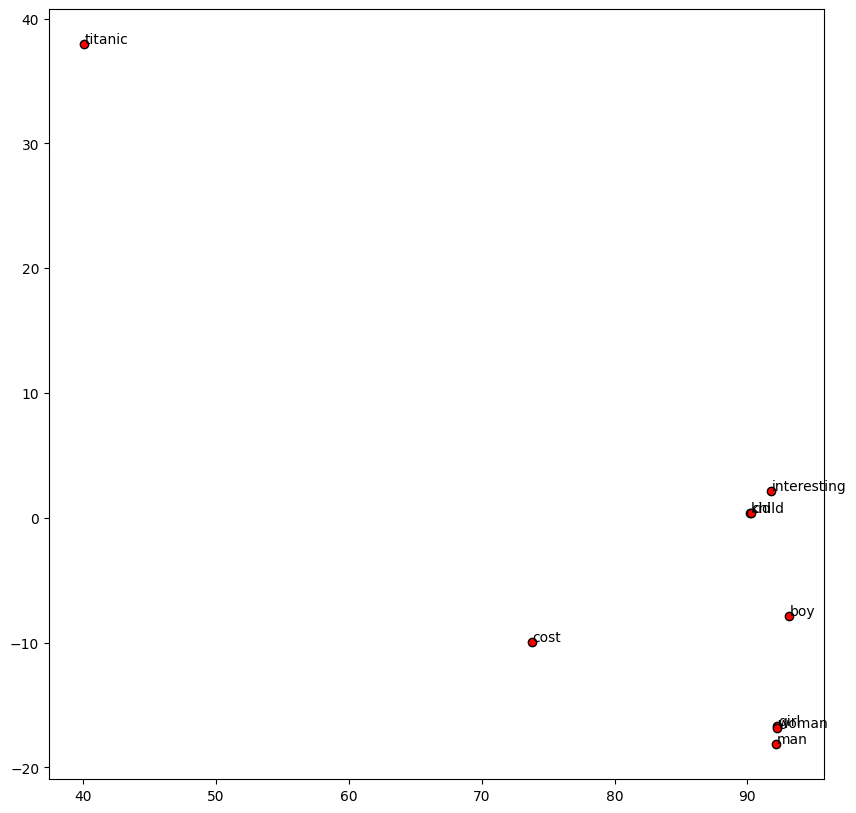

In [138]:
tsne_2d = TSNE(n_components=2, random_state=0)
word_vectors_2d = tsne_2d.fit_transform(reduced_co_occurrence_matrix)

# visualize the word embeddings of a few words
words_to_visualise = words_to_visualise + ['interesting']
word_indices = [word2idx[word] for word in words_to_visualise]
word_vectors = word_vectors_2d[word_indices, :]
plt.figure(figsize=(10, 10))
plt.scatter(word_vectors[:, 0], word_vectors[:, 1], edgecolors='k', c='r')
for word, (x0, x1) in zip(words_to_visualise, word_vectors):
    plt.text(x0+0.05, x1+0.05, word)
plt.show()